In [1]:
import numpy as np
import matplotlib.pyplot as plt
import funky as f
import scipy
import seaborn as sns
rng=np.random.default_rng(seed=1)

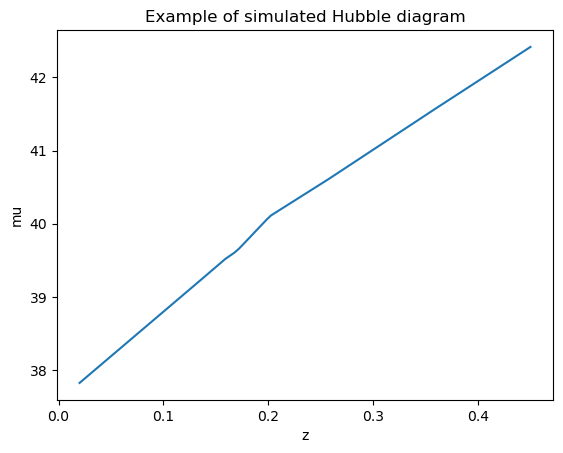

In [3]:
mu, zhd= f.sim_wrapper([0.34,-1],'prova')
z_sim,mu_sim=(f.smoother(zhd,mu))

plt.plot(z_sim,mu_sim)
plt.title('Example of simulated Hubble diagram')
plt.xlabel('z')
plt.ylabel('mu')
plt.show()

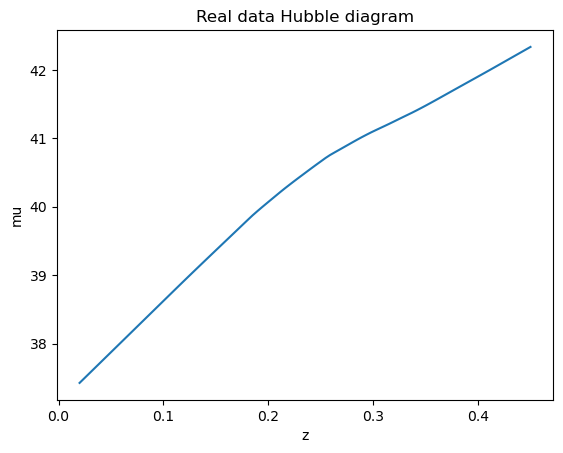

In [4]:
mu_data,z_data=f.extract_mu_zhd_from_file('/home/ubuntu/SNANA/salt2mus/realdata_mus/real.FITRES')
# summary statistic of real data
z_data,mu_data=(f.smoother(z_data,mu_data))

plt.plot(z_data,mu_data)
plt.title('Real data Hubble diagram')
plt.xlabel('z')
plt.ylabel('mu')
plt.show()

In [5]:
# errore si deve aggiornare a ogni trial
# observed data: nel paper sono 200 sampled SNe con omega m =0.27 e w = -1. Ho=72 km s-1 mpc-1.
N=50   


w=np.repeat(1/N,repeats=N)
theta_1=[]
distances=[]

#iterazione t = 1
while len(theta_1)<N:

    # Sample from prior: uniform over 0 < omega < 1, -3 < w < 0.
    theta=np.array([rng.uniform(0,1), rng.uniform(-3,0)])

    # simulate z and mu given choice of theta
    mu_1, z_1= f.sim_wrapper(theta,'prova')
    z_1,mu_1=(f.smoother(z_1,mu_1))

    # compute delta from summary stat. of real data
    delta = np.median(np.abs(mu_data - mu_1))

    # build array
    theta_1.append(theta)
    distances.append(delta)
# final array of 500 particles to perturb.    
theta_t=np.array(theta_1)

# TAU
tau_square=2*np.cov(theta_t, rowvar=False)

tau square:  [[ 0.13823729 -0.01965488]
 [-0.01965488  1.78116173]]


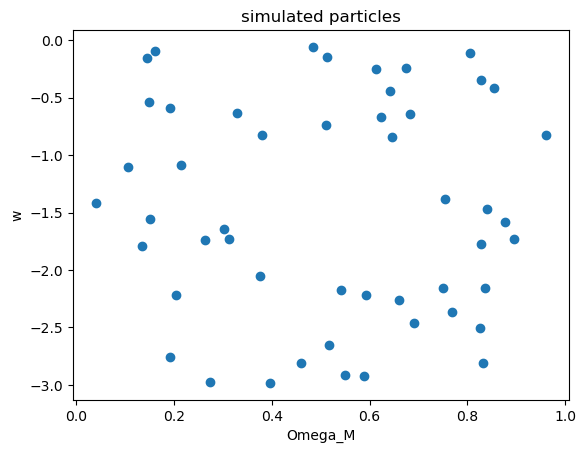

In [6]:
print('tau square: ',tau_square)

plt.scatter(theta_t[:,0],theta_t[:,1])
plt.title('simulated particles')
plt.xlabel('Omega_M')
plt.ylabel('w')
plt.show()

In [7]:
#for quick restart
theta_t=np.array(theta_1)
tau_square=2*np.cov(theta_t, rowvar=False)

In [ ]:
eps= []
medians=[]
acc_rates=[]

medians.append(np.median(distances))
epsilon_t = np.percentile(distances,q=75)
eps.append(epsilon_t)
acc_rates.append(1.)
print('starting epsilon: ',epsilon_t)
k=0
#for t in range(2,T):
while epsilon_t > 0.033:
    k+=1
    print('start iteration',k)
    theta_new=[] # diventerà il nuovo theta_t
    weights_new=[] # diventeranno il nuovo w
    distances_new=[]
    n_proposals=0

    # Voglio N particles che mi piacciono. Alla fine aggiornerò pesi e epsilon
    for i in range(N):
        print('N=',i)
        while True:
            n_proposals+=1
            # sample particle
            idx=rng.choice(range(N),p=w)
            theta_star=theta_t[idx]
            #perturb particle!
            theta_i_t=rng.multivariate_normal(theta_star, tau_square) # propongo un aggiornamento di un theta
            # scarto se sono fuori dal dominio
            if not ((0<theta_i_t[0]<1) and (-3<theta_i_t[1]<0)): continue
            #print(theta_i_t)
            # simulate z and mu given choice of theta
            try:
                mu_i_t, z_i_t= f.sim_wrapper(theta_i_t,'prova',speak=True)
            except: 
                print('ERROR: simulation process failed')
                continue
            z_i_t,mu_i_t=(f.smoother(z_i_t,mu_i_t))

            # create summary statistics
            _,mu_i_t=f.smoother(z_i_t,mu_i_t)

            # compute distance from summary stat. of real data
            delta = np.median(np.abs(mu_data - mu_i_t))
            print('delta proposto: ',delta)
            if delta<epsilon_t:
                print('accettato',theta_i_t)
                break  #Ho trovato una particle che mi piace.
            else: print('rifiutato')
        
        theta_new.append(theta_i_t)
        distances_new.append(delta)

        # aggiorna pesi ---- DA RICONTROLLARE
        denom = 0.0
        for j in range(N):
            denom += w[j] * scipy.stats.multivariate_normal.pdf(x=theta_i_t,mean=theta_t[j],cov=tau_square)
        weight = 1 / denom
        weights_new.append(weight)


    ### Ora ho N particles che mi piacciono. Aggiorno tutto
    print('new theta done! Iteration',k)
    print('acceptance rate: ', N/n_proposals)
    acc_rates.append(N/n_proposals)

    # se media e mediana salgono, tau troppo largo.
    print('mean distances: ',np.mean(distances_new))
    print('median distances: ',np.median(distances_new))
    medians.append(np.median(distances_new))


    # w update
    weights_new=np.array(weights_new)
    w = weights_new / np.sum(weights_new)

    # theta_t update
    theta_t=np.array(theta_new)
    
    #epsilon update
    epsilon_t= np.percentile(distances_new,q=50)
    eps.append(epsilon_t)
    print('epsilon: ',epsilon_t)
    tau_square=2*np.cov(theta_t.T,aweights=w,bias=False)
    # è finita. Ho il mio vettore theta di 500 particelle che seguono la posterior.


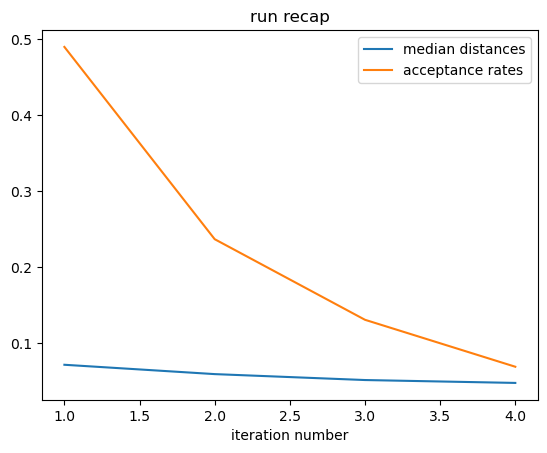

In [8]:
#plt.plot(range(len(eps)),eps,label='epsilon')
plt.plot(range(1,len(medians)+1),medians,label='median distances')
plt.plot(range(1,len(acc_rates)+1),acc_rates, label='acceptance rates')

plt.title ('run recap')
plt.xlabel('iteration number')
plt.legend()
plt.show()